 ## PARAMS

 ### Libraries

In [1]:
# For data manipulation and visualization
import pandas as pd
import numpy as np
import plotnine as pn

# For model building
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split

# For logging
from tqdm import tqdm
import logging

# For other
import os
import sys
import time
from warnings import filterwarnings ; filterwarnings('ignore');
from typing import List, Tuple, Dict, Union, Literal


 ### Utils Functions

In [2]:
class Chrono :
    """Class to measure execution time"""
    def __init__(self):
        self.start_time = 0
        self.end_time = 0
    
    def start(self):
        self.start_time = time.time()
    
    def stop(self):
        self.end_time = time.time()

    def duration(self):
        # Duration in Hours, Minutes and Seconds
        duration = self.end_time - self.start_time
        hours = duration // 3600
        minutes = (duration % 3600) // 60
        seconds = duration % 60
        return f"{int(hours)}h {int(minutes)}m {int(seconds)}s"


In [3]:
class ProgressBarLogger:
    def __init__(self, total=None, desc=None, leave=True):
        self.logger = logging.getLogger(__name__)
        self.pbar = tqdm(total=total, desc=desc, leave=leave)
        self.pbar.n = 0
        self.logger.info(self.pbar.format_dict)

    def update(self, n=1):
        self.pbar.update(n)
        percentage = int(self.pbar.n / self.pbar.total * 100)
        if percentage % 5 == 0:
            self.logger.info(self.pbar.format_dict)

    def close(self):
        self.pbar.close()

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.close()


 ### Constants

In [4]:
# SLURM -------------------------------------------------------------------
try:
    ITER_VALUE = 100 * (1 + int(os.environ['SLURM_NODEID'])) + int(os.environ['SLURM_PROCID']) + 1
except:
    ITER_VALUE = np.random.randint(2000, 10000)

# PATHS  --------------------------------------------------------------------
if sys.platform.startswith('linux') :
    MAIN_PATH = "/lus/work/CT10/cad15178/pvandanjon/these-sane/these-repo"
elif sys.platform.startswith('win') :
    MAIN_PATH = "C:/SANE/These/these-repo"
else :
    MAIN_PATH = "/Users/doctorant/Desktop/These/these-repo"

DATA_PATH = MAIN_PATH + "/output/data-cleaned"
MODELS_PATH = MAIN_PATH + f"/models/models-activity-plan/iter_{ITER_VALUE:04d}"
OUTPUT_PATH = MAIN_PATH + f"/output/EMD_Activity_Plan/iter_{ITER_VALUE:04d}"

# Device -------------------------------------------------------------------
def getDevice() :
    if torch.cuda.is_available() :
        device = torch.device("cuda")
    elif torch.backends.mps.is_available() :
        device = torch.device("mps")
    else :
        device = torch.device("cpu")
    return device

# DATA ENGINEERING  ---------------------------------------------------------
MAX_TRIP_NUMBER = 12
SEED = 42

# TOKENS -------------------------------------------------------------------
PAD_TOKEN = {"ACTION" : "<ACTION_PAD>", "duration" : "<DURATION_PAD", "DISTANCE" : "<DISTANCE_PAD>"}
UNK_TOKEN = "<UNK>"
SOT_TOKEN = "<SOT>"
EOT_TOKEN = {"ACTION" : "<ACTION_EOT>", "duration" : "<DURATION_EOT>", "DISTANCE" : "<DISTANCE_EOT>"}


 ### Initializations

In [5]:
# Create directory if not exists
create_dir = lambda x : os.makedirs(x) if not os.path.exists(x) else None
create_dir(MODELS_PATH)
create_dir(OUTPUT_PATH)

# Chrono 
chrono = Chrono()
chrono.start()

print("\n\n\n")
print("=============================================")
print("               ACTIVITY PLAN JOB             \n") 
print(f"Task ID    : {ITER_VALUE}")
print(f"Start time : {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(chrono.start_time))}")
print("=============================================")
print("\n\n\n")






               ACTIVITY PLAN JOB             

Task ID    : 3840
Start time : 2025-03-31 11:12:24






 ## Data engineering

 #### Importing dat



 We have tree datasets :



 - persons : informations about individuals

 - households : informations about households where individuals live

 - trips : informations about trips of individuals for a typical day

In [6]:
df_households = pd.read_csv(DATA_PATH + "/household.csv", index_col=0)
df_persons    = pd.read_csv(DATA_PATH +  "/persons.csv", index_col=0)
df_trips      = pd.read_csv(DATA_PATH + "/trips.csv", index_col=0)

print("Households : {}".format(df_households.shape))
print("Persons    : {}".format(df_persons.shape))
print("Trips      : {}".format(df_trips.shape))


Households : (12722, 21)
Persons    : (29496, 36)
Trips      : (81924, 37)


 #### Important columns

In [7]:
## IDs
HOUSEHOLD_ID_COL = 'household_id'
PERSON_ID_COL = 'person_id'
TRIP_ID_COL = 'trip_id'

## Households columns
H_NUM_COL = ['household_size', 'number_of_vehicles', 'number_of_bikes']
H_CAT_COL = ['house_type', 'house_occupation_type', 'has_internet']

## Persons columns
P_NUM_COL = [ 'age', 'number_of_trips']
P_CAT_COL = [
    'link_ref_person', 'is_adolescent', 'sex', 'school_level',
    'employed', 'studies', 'has_license',
    'socioprofessional_class',
    'has_pt_subscription', 'travel_respondent', # 'is_passenger',
]

## Trips columns
T_NUM_COL = [
    'mode', 'euclidean_distance', 'routed_distance',
    'departure_time', 'arrival_time', 'trip_duration', 'activity_duration',
]
T_CAT_COL = [
    'is_first_trip', 'is_last_trip', 'following_purpose',
    'preceding_purpose',
] 

## Other columns
HOUSEHOLD_WEIGHT_COL = 'household_weight'
PERSON_WEIGHT_COL = 'person_weight'
TRIP_WEIGHT_COL = 'trip_weight'

## All columns
ALL_COLS = [HOUSEHOLD_ID_COL, HOUSEHOLD_WEIGHT_COL, PERSON_WEIGHT_COL] + H_NUM_COL + H_CAT_COL + P_NUM_COL + P_CAT_COL


#### Weiting the person data

In [8]:

print(f"--> Before weighting : {df_persons.shape}")

df_persons = df_persons.reindex(df_persons.index.repeat(df_persons[PERSON_WEIGHT_COL])).reset_index(drop=True)

print(f"-->  After weighting : {df_persons.shape}")

--> Before weighting : (29496, 36)
-->  After weighting : (1361196, 36)


#### Columns to keep

In [9]:
df_households = df_households[[HOUSEHOLD_ID_COL] + H_NUM_COL + H_CAT_COL]
df_persons = df_persons[[HOUSEHOLD_ID_COL, PERSON_ID_COL] + P_NUM_COL + P_CAT_COL]
df_trips = df_trips[[HOUSEHOLD_ID_COL, PERSON_ID_COL, TRIP_ID_COL, TRIP_WEIGHT_COL] + T_NUM_COL + T_CAT_COL]


 #### Rows to keep

In [10]:
# Remove persons with more than 12 trips
df_persons = df_persons[(df_persons['number_of_trips'] >= 0) & (df_persons['number_of_trips'] <= MAX_TRIP_NUMBER)]

# Keep only households with persons with less than 12 trips
df_households = df_households.loc[df_households[HOUSEHOLD_ID_COL].isin(df_persons[HOUSEHOLD_ID_COL])]

# Keep only trips of persons with less than 12 trips
df_trips = df_trips.loc[df_trips[PERSON_ID_COL].isin(df_persons[PERSON_ID_COL])]


 #### Trips data exploration

In [11]:
df_trips.head(10)


,household_id,person_id,trip_id,trip_weight,mode,euclidean_distance,routed_distance,departure_time,arrival_time,trip_duration,activity_duration,is_first_trip,is_last_trip,following_purpose,preceding_purpose
0,0,0,0,44.02199,pt,17887,26830,27000.0,30600.0,3600.0,31800.0,True,False,leisure,home
1,0,0,1,44.02199,pt,17887,26830,62400.0,66000.0,3600.0,NaN,False,True,home,leisure
2,1,1,2,64.82165,car,12507,14777,28800.0,30600.0,1800.0,16200.0,True,False,work,home
3,1,1,3,64.82165,car,12507,14975,46800.0,48900.0,2100.0,5100.0,False,False,home,work
4,1,1,4,64.82165,walk,580,667,54000.0,54600.0,600.0,600.0,False,False,shop,home
5,1,1,5,64.82165,walk,58,67,55200.0,55260.0,60.0,300.0,False,False,shop,shop
6,1,1,6,64.82165,walk,58,67,55560.0,55620.0,60.0,300.0,False,False,shop,shop
7,1,1,7,64.82165,walk,290,333,55920.0,56220.0,300.0,600.0,False,False,shop,shop
8,1,1,8,64.82165,walk,116,133,56820.0,56940.0,120.0,600.0,False,False,shop,shop
9,1,1,9,64.82165,walk,290,333,57540.0,57840.0,300.0,NaN,False,True,home,shop


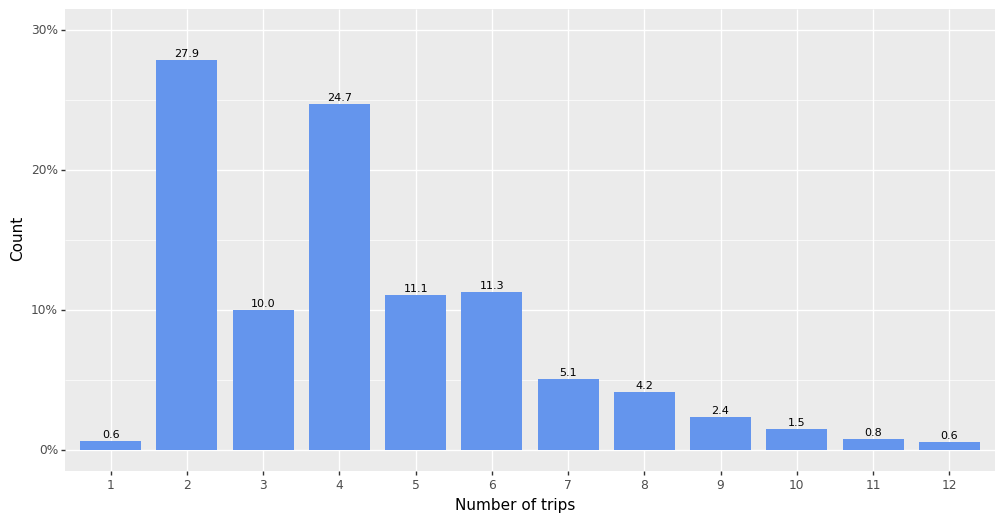

<ggplot: (8764460259723)>

In [12]:
df_plot = df_trips.groupby(by=[PERSON_ID_COL]).size().reset_index(name='counts')
(
    pn.ggplot(df_plot)
    + pn.aes(x='counts', y=pn.after_stat('prop'))
    + pn.geom_bar(width=.8, fill='cornflowerblue')
    + pn.geom_text(pn.aes(label=pn.after_stat('np.round(prop*100, 1)')), stat='count', nudge_y=0.005, size=8)
    + pn.scale_x_discrete(limits=np.arange(1, np.max(df_plot['counts']) + 1))
    + pn.scale_y_continuous(labels = lambda l: ["{:0.0f}%".format(v * 100) for v in l])
    + pn.expand_limits(y=0.3)
    + pn.labs(x="Number of trips", y="Count")
    + pn.theme(figure_size=(12, 6))
)


 ##### 1. Duration



 The trip duration is given in seconds. We will convert it in minutes. The following graphs show the distribution of the trip duration in minutes. We can see that the distribution has many peaks. Also, we can see that the distribution has a long tail after 60 minutes.



In [13]:
def ggpraph_1(df, col, xlab="", ylab="Density", xbreak=True, ybreak=True ) :
    return (
        pn.ggplot(df) 
        + pn.aes(x=col, color="following_purpose")
        + pn.geom_density(pn.aes(fill=pn.after_scale("color + '40'")), alpha=0.2)
        + pn.scale_x_continuous(
            labels= lambda labs : [f"{x:2.0f}" for x in labs],
            breaks = xbreak,
        )
        + pn.scale_y_continuous(
            labels = lambda labs : [f"{(x*100).round():2.0f}%" for x in labs],
            breaks = ybreak,

        )
        + pn.scale_color_discrete(labels=lambda labs : [f"{x.title()}" for x in labs])
        + pn.labs(x=xlab, y="Density", color="")
        + pn.theme_538()
        + pn.theme(
            figure_size=(14, 6),
            legend_position=(0.85, 0.7),
            legend_direction="vertical",
            legend_background=pn.element_blank(),
        )
    )


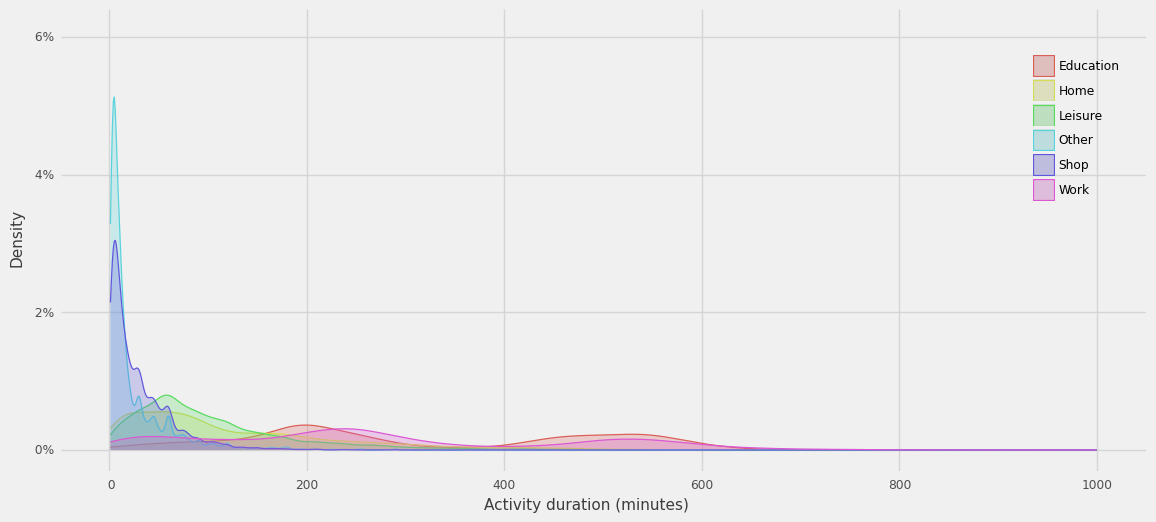

In [14]:
## Activities duration

df_plot = df_trips[df_trips["activity_duration"] > 0]
df_plot["activity_duration"] = (df_plot["activity_duration"] / 60).round()

g1 = (
    ggpraph_1(df_plot, "activity_duration", "Activity duration (minutes)", xbreak=np.arange(0, 2000, 200), ybreak=np.arange(0, 0.121, 0.02))
    + pn.expand_limits(y=(0, 0.061))
)

print(g1)


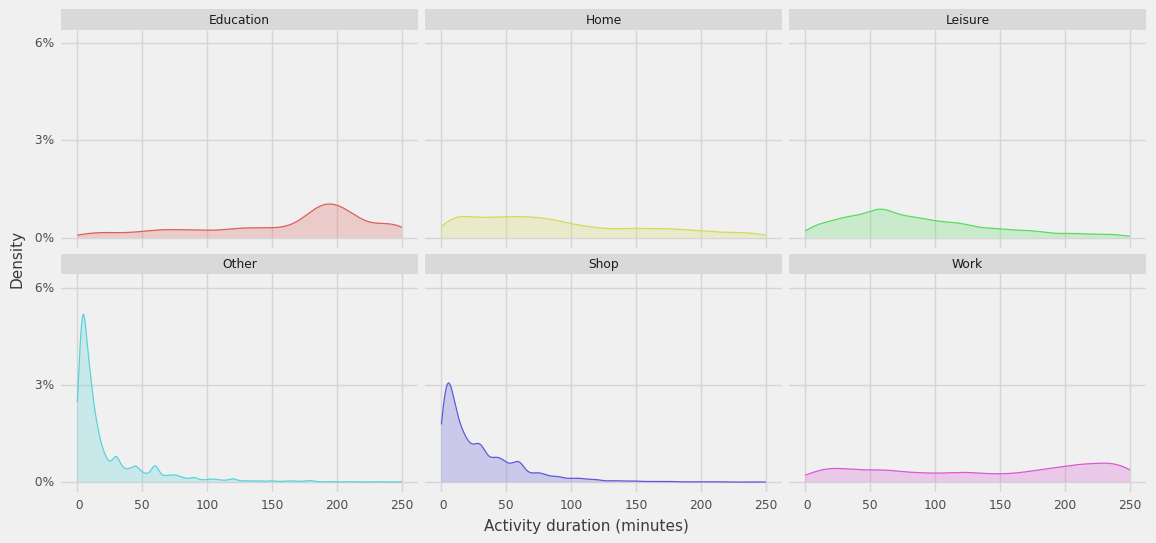

In [15]:
g2 = ( 
    ggpraph_1(df_plot, "activity_duration", "Activity duration (minutes)", xbreak=np.arange(0, 2000, 200), ybreak=np.arange(0, 0.121, 0.03))
    + pn.facet_wrap("~following_purpose",  labeller= lambda x : x.title())
    + pn.scale_x_continuous(
        labels= lambda labs : [f"{x:2.0f}" for x in labs], 
        limits=(0, 250),
        # breaks = np.arange(0, 76, 15),
    )
    + pn.expand_limits(y=(0, 0.061))
    + pn.theme(
        legend_position="none",
        # panel_spacing_y=0.3,
    )
)

print(g2)


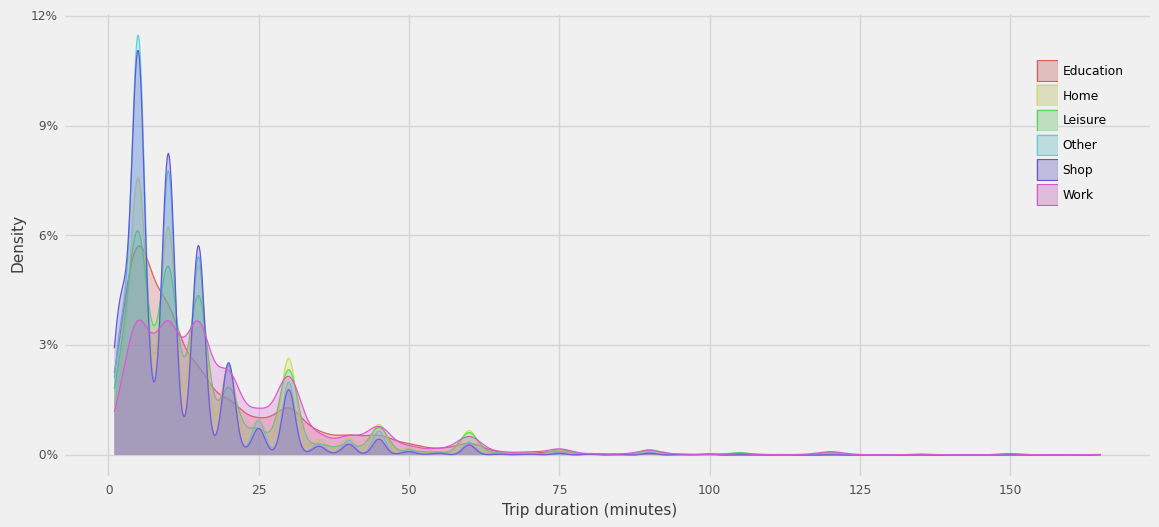

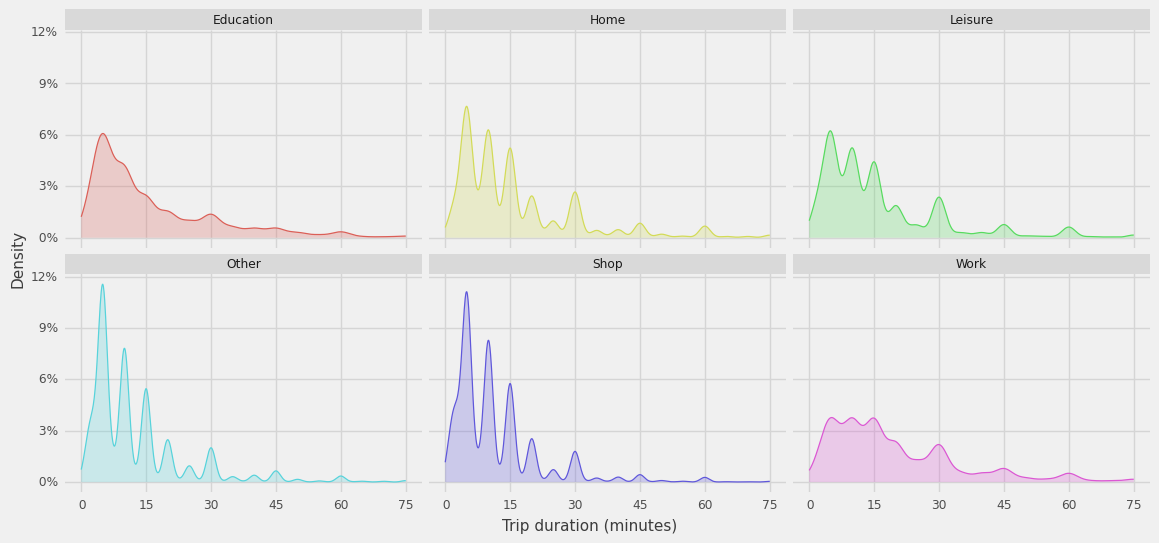

In [16]:
## Trips duration

df_plot = df_trips[df_trips["trip_duration"] < 10000]
df_plot["trip_duration"] = (df_plot["trip_duration"] / 60).round()

g1 = ggpraph_1(df_plot, "trip_duration", "Trip duration (minutes)", xbreak=np.arange(0, 200, 25), ybreak=np.arange(0, 0.121, 0.03))
g2 = ( 
    ggpraph_1(df_plot, "trip_duration", "Trip duration (minutes)", xbreak=np.arange(0, 200, 25), ybreak=np.arange(0, 0.121, 0.03))
    + pn.facet_wrap("~following_purpose", labeller= lambda x : x.title())
    + pn.scale_x_continuous(
        labels= lambda labs : [f"{x:2.0f}" for x in labs], 
        limits=(0, 75),
        breaks = np.arange(0, 76, 15),
    )
    + pn.theme(
        legend_position="none",
    )
)

print(g1)
print(g2)


 #### Feature engineering

 ##### Recoding functions

In [17]:
## Recode functions
def recode_categorical(dat : pd.DataFrame, recode_info:dict) -> pd.DataFrame:
    """Recode categorical columns

    Args:
        dat (pd.DataFrame): Dataframe to recode
        recode_info (dict): Dictionary of columns to recode

    Returns:
        pd.DataFrame: Dataframe with recoded columns
    """

    new_dat = dat.copy()
    for col in recode_info.keys() : 
        for k, v in recode_info[col].items() : 
            new_dat.loc[dat[col].isin(v), col] = k 
        new_dat[col] = new_dat[col].astype(object)
    return new_dat

def recode_numerical(dat : pd.DataFrame, recode_info:dict) -> pd.DataFrame:

    """Recode numerical columns

    Args:
        dat (pd.DataFrame): Dataframe to recode
        recode_info (dict): Dictionary of columns to recode

    Returns:
        pd.DataFrame: Dataframe with recoded columns
    """

    new_dat = dat.copy()
    for col in recode_info.keys() :
        tmp = np.array(dat[col].values)
        for k, v in recode_info[col].items() :
            a = tmp >= v[0]
            b = tmp < v[1]
            new_dat.loc[ a & b, col] = k 
        new_dat[col] = new_dat[col].astype(object)
    return new_dat



In [18]:
df_persons['school_level'].unique()


array(['primary', 'bac3_more', 'high', 'bac1_bac2', 'other'], dtype=object)

 ##### Households dataset recoding

In [19]:
h_cat_recode_info = {}

h_num_recode_info = {
    'household_size' : {
        '1' : [1, 2],
        '2' : [2, 3],
        '3' : [3, 4],
        '4' : [4, 5],
        '5' : [5, 20],
    }, 
    'number_of_vehicles' : {
        '0' : [0, 1],
        '1' : [1, 2],
        '2' : [2, 3],
        '3' : [3, 4],
        '4+' : [4, 20],
    }, 
    'number_of_bikes' : {
        '0' : [0, 1],
        '1-2' : [1, 3],
        '3-4' : [3, 5],
        '5+' : [5, 20], 
    }, 
}

df_households = recode_categorical(df_households, h_cat_recode_info)
df_households = recode_numerical(df_households, h_num_recode_info)


 ##### Persons dataset recoding

In [20]:
h_cat_recode_info = {
    'school_level' : {
        'high school' : ['high'],
        'primary' : ['primary'],
        'bac1_bac2' : ['bac1_bac2'],
        'bac3_more' : ['bac3_more'],
        'other' : ['other'],
    },  
    'socioprofessional_class': {
        'retired' : ['retired'], 
        'employee' : ['employee'], 
        'intermediate_profession' : ['intermediate_profession'],
        'unemployed_never_worked' : ['unemployed_never_worked', 'student'], 
        'farmer' : ['farmer'], 
        'worker' : ['worker'],
        'manager_intellectual_professions' : ['manager_intellectual_professions'],
        'craftsman_trader_entrepreneur' : ['craftsman_trader_entrepreneur'],
    },
}

p_num_recode_info = { 
    'age' : {
        '00-14 yo' : [0, 15],
        '15-29 yo' : [15, 30],
        '30-44 yo' : [30, 45],
        '45-59 yo' : [45, 60],
        '60-74 yo' : [60, 75],
        '75 yo and +' : [75, 150]
    },
}

df_persons = recode_categorical(df_persons, h_cat_recode_info)
df_persons = recode_numerical(df_persons, p_num_recode_info)


 ##### Pivot trips dataset into a actions dataset

In [21]:
## AddI ID to the trips by person
df_trips = df_trips.sort_values(by=[PERSON_ID_COL, 'departure_time'])
df_trips['trip_rank'] = df_trips.sort_values(by=[PERSON_ID_COL, 'departure_time']).groupby(PERSON_ID_COL).cumcount()


In [22]:
df_trip_actions = {}

## Initial purpose
df_trip_actions["initial_purpose"] = df_trips.loc[df_trips['trip_rank'] == 0, [PERSON_ID_COL, 'trip_rank', 'preceding_purpose', 'departure_time']]
df_trip_actions["initial_purpose"] = df_trip_actions["initial_purpose"].rename(columns={'preceding_purpose' : 'action', 'departure_time' : 'duration'})
df_trip_actions["initial_purpose"]['distance'] = 0
df_trip_actions["initial_purpose"] = df_trip_actions["initial_purpose"][[PERSON_ID_COL, 'trip_rank', 'action', 'duration', 'distance']]
df_trip_actions["initial_purpose"]['trip_action_rank'] = 0

## Current travel mode
df_trip_actions["mode"] = df_trips[[PERSON_ID_COL, 'trip_rank', 'mode', 'trip_duration', 'euclidean_distance']]
df_trip_actions["mode"] = df_trip_actions["mode"].rename(columns={'mode' : 'action', 'euclidean_distance' : 'distance', 'trip_duration' : 'duration'})
df_trip_actions["mode"]['trip_action_rank'] = 1

## Current activity
df_trip_actions["activity"] = df_trips[[PERSON_ID_COL, TABLE_TRIP_REQUIRED_COLUMNS = ["initial_purpose", "preceding_purpose", "departure_time", 'trip_rank', 'mode', 'trip_duration', 'euclidean_distance', ]
]]
df_trip_actions["activity"] = df_trip_actions["activity"].rename(columns={'following_purpose' : 'action', 'activity_duration' : 'duration'})
df_trip_actions["activity"]['distance'] = 0
df_trip_actions["activity"]['duration'] = df_trip_actions["activity"][['duration', 'arrival_time', 'is_last_trip']].apply(lambda x : 24*60*60 - x[1] if x[2] == 1 else x[0], axis=1)
df_trip_actions["activity"]['duration'] = df_trip_actions["activity"]['duration'].apply(lambda x : (4*60*60 + x) if x < 0 else x) # A revoir avec les en
df_trip_actions["activity"] = df_trip_actions["activity"][[PERSON_ID_COL, 'trip_rank', 'action', 'duration', 'distance']]
df_trip_actions["activity"]['trip_action_rank'] = 2

## Merge all actions
df_actions = pd.concat(df_trip_actions.values())
df_actions = df_actions.sort_values(by=[PERSON_ID_COL, 'trip_rank', 'trip_action_rank'])
df_actions['person_action_id'] = df_actions.sort_values(by=[PERSON_ID_COL, 'trip_rank', 'trip_action_rank']).groupby(PERSON_ID_COL).cumcount()
df_actions = df_actions[[PERSON_ID_COL, 'person_action_id',  'action', 'duration', 'distance']]

# ## Check if there is no missing values
assert df_actions.isnull().sum().sum() == 0, "There are missing values in the actions dataframe"

##  Recode duration
df_actions.head(10)


,person_id,person_action_id,action,duration,distance
0,0,0,home,27000.0,0
0,0,1,pt,3600.0,17887
0,0,2,leisure,31800.0,0
1,0,3,pt,3600.0,17887
1,0,4,home,20400.0,0
2,1,0,home,28800.0,0
2,1,1,car,1800.0,12507
2,1,2,work,16200.0,0
3,1,3,car,2100.0,12507
3,1,4,home,5100.0,0


 ##### Actions dataset recoding

In [23]:
# Cut duration and distance
def cut_duration(dat) :
    dat = dat / 60
    bins = np.concatenate((
        np.arange(0, 1e-3, 1e-3),
        np.arange(1e-3, 26, 5),
        np.arange(30, 180, 15),
        np.arange(180, 480, 30),
        np.arange(480, 1440, 60),
        np.arange(1440, 2880, 120),
        np.arange(2880, 4320, 180),
    )).tolist()
    return pd.cut(dat, bins=bins, include_lowest=True, labels=[f"{x//60:02.0f}h{x%60:02.0f}" for x in bins[1:]]).astype(str)

def cut_distance(dat) :
    dat = dat / 1000
    bins =  np.concatenate((
        np.arange(0, 1e-3, 1e-3),
        np.arange(1e-3, 5, 0.5), 
        np.arange(5, 10, 1),
        np.arange(10, 20, 2),
        np.arange(20, 50, 5),
        np.arange(50, 100, 10),
        np.arange(100, 200, 20),
        np.arange(200, 500, 50),
        np.arange(500, 1000, 100),
        np.arange(1000, 2000, 200),
    )).tolist()
    
    return pd.cut(dat, bins=bins, include_lowest=True, labels=[f"{x:06.1f}" for x in bins[1:]]).astype(str) #labels=[f"{x:06.1f}-{y:06.1f}" for x, y in zip(bins[:-1], bins[1:])])


In [24]:
df_actions['duration'] = cut_duration(df_actions['duration'])
df_actions['distance'] = cut_distance(df_actions['distance'])
df_actions.head()


,person_id,person_action_id,action,duration,distance
0,0,0,home,07h30,0000.0
0,0,1,pt,01h00,0018.0
0,0,2,leisure,09h00,0000.0
1,0,3,pt,01h00,0018.0
1,0,4,home,06h00,0000.0


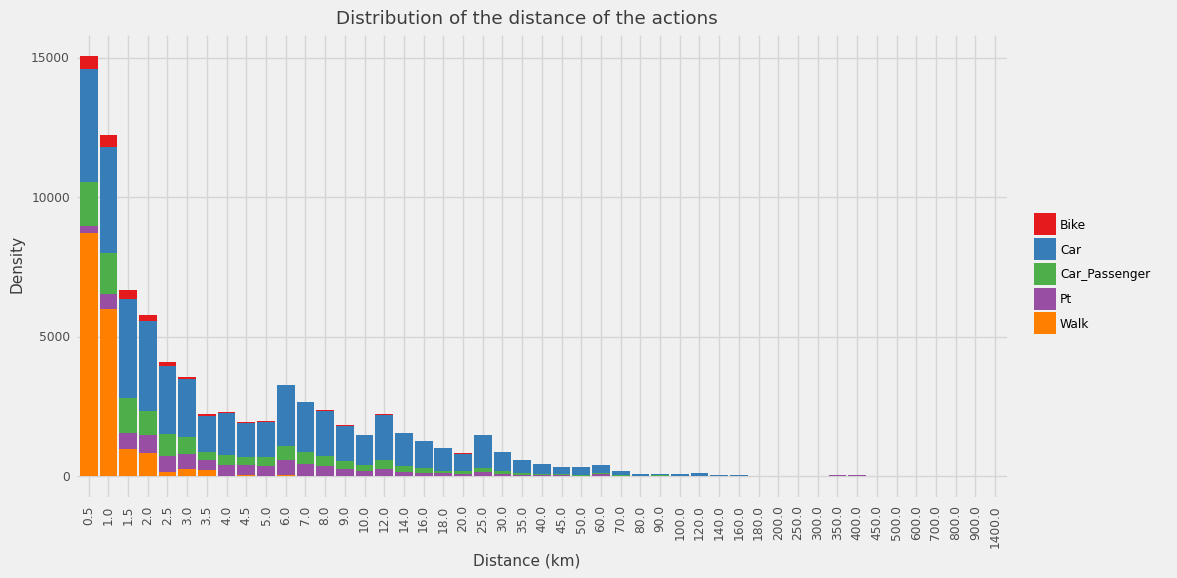

<ggplot: (8764431255995)>

In [25]:
df_plot = df_actions.loc[ df_actions['distance'].apply(lambda x : float(x)) > 0].copy()
(
    pn.ggplot(df_plot)
    + pn.aes(x='distance', fill='action')
    + pn.geom_bar()
    + pn.scale_x_discrete(labels = lambda labs : [f"{float(x)}" for x in labs])
    + pn.scale_fill_brewer(type='qualitative', palette=6, labels = lambda labs : [f"{x.title()}" for x in labs])
    + pn.labs(x="Distance (km)", y="Density", fill="", title="Distribution of the distance of the actions")
    + pn.theme_538()
    + pn.theme(
        figure_size=(12, 6),
        axis_text_x=pn.element_text(angle=90),
    )
)


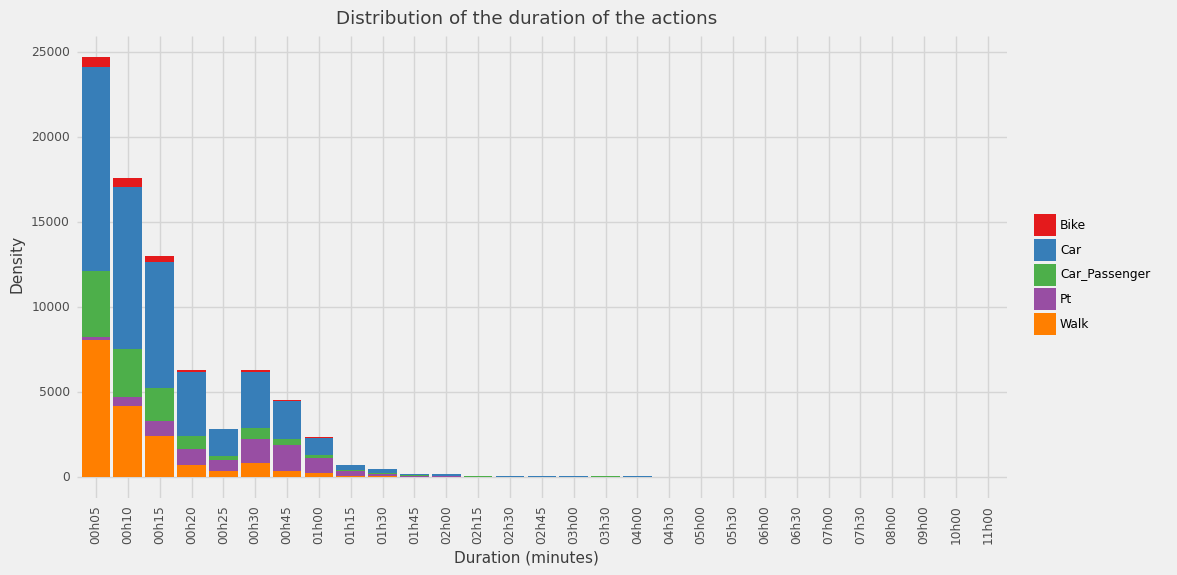

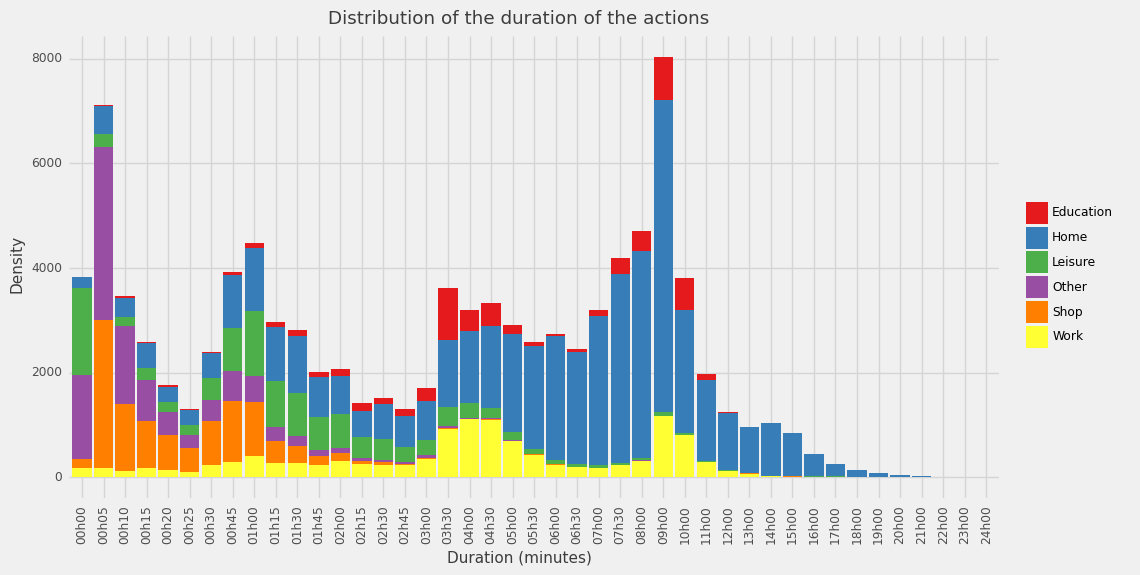

In [26]:

df_plot = df_actions[df_actions['action'].isin(df_trips['mode'].unique())].copy()
g1 = (
    pn.ggplot(df_plot)
    + pn.aes(x='duration', fill='action')
    + pn.geom_bar()
    + pn.scale_fill_brewer(type='qualitative', palette=6, labels = lambda labs : [f"{x.title()}" for x in labs])
    + pn.labs(x="Duration (minutes)", y="Density", fill="", title="Distribution of the duration of the actions")
    + pn.theme_538()
    + pn.theme(
        figure_size=(12, 6),
        axis_text_x=pn.element_text(angle=90),
    )
)


df_plot = df_actions[df_actions['action'].isin(df_trips['following_purpose'].unique())].copy()
g2 = (
    pn.ggplot(df_plot)
    + pn.aes(x='duration', fill='action')
    + pn.geom_bar()
    + pn.scale_fill_brewer(type='qualitative', palette=6, labels = lambda labs : [f"{x.title()}" for x in labs])
    + pn.labs(x="Duration (minutes)", y="Density", fill="", title="Distribution of the duration of the actions")
    + pn.theme_538()
    + pn.theme(
        figure_size=(12, 6),
        axis_text_x=pn.element_text(angle=90),
    )
)

print(g1)
print(g2)


In [27]:
## Add end of action
def add_end_of_action(dat) :
    max_rank = dat['person_action_id'].max()
    eot = dat.loc[dat['person_action_id'] == max_rank]
    eot.iloc[:, 2:] = EOT_TOKEN.values()
    eot['person_action_id'] = max_rank + 1

    ## Add end of action to dat
    return pd.concat([dat, eot])

df_actions = df_actions.groupby(by=[PERSON_ID_COL], as_index=False).apply(add_end_of_action).reset_index(drop=True)
df_actions.head(10)


,person_id,person_action_id,action,duration,distance
0,0,0,home,07h30,0000.0
1,0,1,pt,01h00,0018.0
2,0,2,leisure,09h00,0000.0
3,0,3,pt,01h00,0018.0
4,0,4,home,06h00,0000.0
5,0,5,<ACTION_EOT>,<DURATION_EOT>,<DISTANCE_EOT>
6,1,0,home,08h00,0000.0
7,1,1,car,00h30,0014.0
8,1,2,work,04h30,0000.0
9,1,3,car,00h45,0014.0


 ##### Pivot wider actions table to have one row per person

In [28]:
# Pivot wider actions table to have one row per person and ordered actions
PERSON_ACTION_MAX_ID = df_actions['person_action_id'].max()

df_person_actions = df_actions.pivot(index=PERSON_ID_COL, columns='person_action_id').reset_index()
df_person_actions.columns = [f"{x}_{y}" for x, y in df_person_actions.columns]
df_person_actions = df_person_actions.rename(columns={f"{PERSON_ID_COL}_" : PERSON_ID_COL})
df_person_actions = df_person_actions.sort_values(by=[PERSON_ID_COL])
df_person_actions = df_person_actions[[PERSON_ID_COL] + np.concatenate(([[f"action_{i}", f"duration_{i}", f"distance_{i}"] for i in range(PERSON_ACTION_MAX_ID)])).tolist()]
df_person_actions.head()


,person_id,action_0,duration_0,distance_0,action_1,duration_1,distance_1,action_2,duration_2,distance_2,...,distance_21,action_22,duration_22,distance_22,action_23,duration_23,distance_23,action_24,duration_24,distance_24
0,0,home,07h30,0000.0,pt,01h00,0018.0,leisure,09h00,0000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,home,08h00,0000.0,car,00h30,0014.0,work,04h30,0000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,home,08h00,0000.0,walk,00h15,0001.0,work,11h00,0000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,home,07h30,0000.0,pt,00h20,0004.0,education,10h00,0000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,home,07h30,0000.0,walk,00h15,0001.0,education,04h30,0000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


 #### Class Prefixer

In [29]:
class Prefixer:
    """
        Add colname to values like a prefix
    """
    def __init__(self, data):
        self.data = data

    
    def transform(self, colname):
        return self.data[colname].apply(lambda x : f"{colname}_{x}")
    
    def inverse_transform(self, colname):
        return self.data[colname].apply(lambda x : x.replace(f"{colname}_", ""))
    
    def transform_all(self, exclude=[], include=[]):
        for col in self.data.columns:
            if col not in exclude and (len(include) == 0 or col in include):
                self.data[col] = self.transform(col)
        return self.data
    
    def inverse_transform_all(self, exclude=[], include=[]):
        for col in self.data.columns:
            if col not in exclude and (len(include) == 0 or col in include):
                self.data[col] = self.inverse_transform(col)
        return self.data



In [30]:
hh_prefixer = Prefixer(df_households)
df_households = hh_prefixer.transform_all(exclude=[HOUSEHOLD_ID_COL])

pers_prefixer = Prefixer(df_persons)
df_persons = pers_prefixer.transform_all(exclude=[HOUSEHOLD_ID_COL, PERSON_ID_COL])


 ### Merge datasets and transform to string

In [31]:
## Merge all dataframes
df = df_households.merge(df_persons, on=HOUSEHOLD_ID_COL, how='left').assign(sot=SOT_TOKEN).merge(df_person_actions, on=PERSON_ID_COL, how='right')
df = df.drop(columns=[HOUSEHOLD_ID_COL, PERSON_ID_COL])

## Fill missing values
df[[c for c in df.columns if c.startswith("action_")]] = df[[c for c in df.columns if c.startswith("action_")]].fillna(PAD_TOKEN["ACTION"])
df[[c for c in df.columns if c.startswith("duration_")]] = df[[c for c in df.columns if c.startswith("duration_")]].fillna(PAD_TOKEN["duration"])
df[[c for c in df.columns if c.startswith("distance_")]] = df[[c for c in df.columns if c.startswith("distance_")]].fillna(PAD_TOKEN["DISTANCE"])

print("==================================")
print("Shape :", df.shape)
print("==================================")


Shape : (936670, 94)


 ### Splitting the dataset

In [32]:
## Split data
df_train, df_val = train_test_split(df, test_size=0.25, random_state=SEED)

print("==================================")
print("Train shape :", df_train.shape)
print("Val shape :", df_val.shape)
print("==================================")


Train shape : (702502, 94)
Val shape : (234168, 94)


 ### Tokenizer

In [33]:
class Tokenizer :
    """
    Attributes:
        pad_token (str): Padding token.
        unk_token (str): Unknown token.
        sot_token (str): Start of text token.
        eot_token (str): End of text token.
        word2idx (dict): Dictionary mapping words to their indices.
        idx2word (dict): Dictionary mapping indices to their words.
        name2idx (dict): Dictionary mapping names to their indices.
        vocab_size (int): Size of the vocabulary.
        name_vocab_size (dict): Dictionary mapping names to their vocabulary sizes.
    Methods:
        __init__(self, sot_token=SOT_TOKEN, eot_token=EOT_TOKEN, pad_token=PAD_TOKEN, unk_token=UNK_TOKEN):
        _build_vocab(self):
        _add_word(self, word):
        add_words(self, words: Union[List, Tuple, str, np.array, np.ndarray], name: Literal[None, 'action', 'duration', 'distance'] = None):
        _add_word_to(self, name, word):
        encode(self, words: Union[str, List, Tuple, np.array, np.ndarray]):
        decode(self, index: Union[int, List[int], Tuple[int], np.array, np.ndarray]):
        encode_name(self, name, words: Union[str, List, Tuple, np.array, np.ndarray]):
        decode_name(self, name, index: Union[int, List[int], Tuple[int], np.array, np.ndarray]):
        encode_from_name(self, name, words: Union[str, List, Tuple, np.array, np.ndarray]):
        decode_from_name(self, name, index: Union[int, List[int], Tuple[int], np.array, np.ndarray]):
        save(self, path):
        load(self, path):
        __len__(self):
            Returns the size of the vocabulary.
        __repr__(self):
            Returns a string representation of the Tokenizer object.
    """
    
    def __init__(self, sot_token=SOT_TOKEN, eot_token=EOT_TOKEN, pad_token=PAD_TOKEN, unk_token=UNK_TOKEN) :
        """
        Initializes the tokenizer with special tokens and builds the vocabulary.

        Args:
            sot_token (str): Start of text token. Default is SOT_TOKEN.
            eot_token (str): End of text token. Default is EOT_TOKEN.
            pad_token (str): Padding token. Default is PAD_TOKEN.
            unk_token (str): Unknown token. Default is UNK_TOKEN.
        """
        self.pad_token = pad_token
        self.unk_token = unk_token
        self.sot_token = sot_token
        self.eot_token = eot_token
        self.word2idx = {}
        self.idx2word = {}
        self.name2idx = {"action" : {}, "duration" : {}, "distance" : {}}
        self.idx2name = {"action" : {}, "duration" : {}, "distance" : {}}
        self.vocab_size = 0
        self.name_vocab_size = {"action" : 0, "duration" : 0, "distance" : 0}
        self._build_vocab()

    def _build_vocab(self) :
        """
        Builds the vocabulary for the tokenizer by adding special tokens.

        This method adds the following tokens to the vocabulary:
        - Padding tokens (pad_token)
        - End of text tokens (eot_token)
        - Unknown token (unk_token)
        - Start of text token (sot_token)

        Each token is added in lowercase.

        Returns:
            None
        """
        for k, v in self.pad_token.items() :
            self._add_word_to(k.lower(), v)
        for k, v in self.eot_token.items() :
            self._add_word_to(k.lower(), v)
        self._add_word(self.unk_token)
        self._add_word(self.sot_token)

    def _add_word(self, word) :
        """
        Adds a word to the vocabulary.

        If the word is not already in the vocabulary, it assigns the word a new index,
        updates the word-to-index and index-to-word mappings, and increments the vocabulary size.

        Args:
            word (str): The word to be added to the vocabulary.

        Returns:
            None
        """
        if word not in self.word2idx :
            self.word2idx[word] = self.vocab_size
            self.idx2word[self.vocab_size] = word
            self.vocab_size += 1

    def add_words(self, words: Union[List, Tuple, str, np.array, np.ndarray], name: Literal[None, 'action', 'duration', 'distance'] = None):
        """
        Adds words to the internal storage and optionally associates them with a category.

        Parameters:
        words (Union[List, Tuple, str, np.array, np.ndarray]): The words to be added. Can be a single string, a list, a tuple, or a numpy array of strings.
        name (Literal[None, 'action', 'duration', 'distance'], optional): The category to associate the words with. Defaults to None.

        Returns:
        None
        """
        if type(words) == str :
            self._add_word(words)
            if name is not None :
                self._add_word_to(name, words)
        elif type(words) == list or type(words) == tuple :
            for word in words :
                self._add_word(word)
                if name is not None :
                    self._add_word_to(name, word)
        elif type(words) == np.array or type(words) == np.ndarray :
            for word in words.flatten() :
                self._add_word(word)
                if name is not None :
                    self._add_word_to(name, word)

    def _add_word_to(self, name, word) : 
        """
        Adds a word to the vocabulary for a given name if it is not already present.

        Args:
            name (str): The name of the vocabulary to which the word should be added.
            word (str): The word to be added to the vocabulary.

        Returns:
            None
        """
        if word not in self.name2idx[name] :
            self.name2idx[name][word] = self.name_vocab_size[name]
            self.idx2name[name][self.name_vocab_size[name]] = word
            self.name_vocab_size[name] += 1

    def encode(self, words : Union[str, List, Tuple, np.array, np.ndarray]) :
        """
        Encodes a given input of words into their corresponding indices based on the word2idx dictionary.

        Parameters:
        words (Union[str, List, Tuple, np.array, np.ndarray]): The input words to encode. It can be a single string, 
                                                               a list or tuple of strings, or a numpy array of strings.

        Returns:
        Union[int, List[int], np.ndarray]: The encoded indices of the input words. If the input is a single string, 
                                           an integer is returned. If the input is a list or tuple, a list of integers 
                                           is returned. If the input is a numpy array, a numpy array of integers is returned.
        """
        if type(words) == str :
            return self.word2idx.get(words, self.word2idx[self.unk_token])
        elif type(words) == list or type(words) == tuple :
            return [self.word2idx.get(word, self.word2idx[self.unk_token]) for word in words]
        elif type(words) == np.array or type(words) == np.ndarray :
            out = [self.word2idx.get(word, self.word2idx[self.unk_token]) for word in words.flatten()]
            return np.array(out).reshape(words.shape)
        
    def decode(self, index : Union[Union[int, List, Tuple, np.array, np.ndarray]] ) :
        """
        Decodes the given index or indices into corresponding words.

        Parameters:
        index (Union[int, List[int], Tuple[int], np.array, np.ndarray]): The index or indices to decode. 
            It can be a single integer, a list of integers, a tuple of integers, or a numpy array of integers.

        Returns:
        Union[str, List[str], np.ndarray]: The decoded word(s). 
            If the input is a single integer, a single word (str) is returned.
            If the input is a list or tuple, a list of words (List[str]) is returned.
            If the input is a numpy array, a numpy array of words (np.ndarray) is returned.
        """
        if type(index) == int :
            return self.idx2word.get(index, self.unk_token)
        elif type(index) == list or type(index) == tuple :
            return [self.idx2word.get(i, self.unk_token) for i in index]
        elif type(index) == np.array or type(index) == np.ndarray : 
            out = [self.idx2word.get(i, self.unk_token) for i in index.flatten()]
            return np.array(out).reshape(index.shape)
        
    def convert_index_to_name(self, name: Literal['action', 'duration', 'dustance'], index) :
        """
        Converts the index of a word from the general vocabulary to the index of the word in a given name.

        Args:
            name (str): The name of the vocabulary to which the index is converted.
            index (Union[int, List[int], Tuple[int], np.array, np.ndarray]): The index or indices to convert. 
                It can be a single integer, a list of integers, a tuple of integers, or a numpy array of integers.

        Returns:
            Union[int, List[int], np.ndarray]: The index or indices of the word(s) in the given vocabulary.
        """
        if type(index) == int :
            return self.name2idx[name].get(self.idx2word.get(index, self.unk_token), self.unk_token)
        elif type(index) == list or type(index) == tuple :
            return [self.name2idx[name].get(self.idx2word.get(i, self.unk_token), self.unk_token) for i in index]
        elif type(index) == np.array or type(index) == np.ndarray :
            out = [self.name2idx[name].get(self.idx2word.get(i, self.unk_token), self.unk_token) for i in index.flatten()]
            return np.array(out).reshape(index.shape)
        
    def convert_index_from_name(self, name, index) :
        """
        Converts the index of a word from a given name to the index of the word in the general vocabulary.

        Args:
            name (str): The name of the vocabulary from which the index is taken.
            index (Union[int, List[int], Tuple[int], np.array, np.ndarray]): The index or indices to convert. 
                It can be a single integer, a list of integers, a tuple of integers, or a numpy array of integers.

        Returns:
            Union[int, List[int], np.ndarray]: The index or indices of the word(s) in the general vocabulary.
        """
        if type(index) == int :
            return self.word2idx.get(self.idx2name[name].get(index, self.unk_token), self.unk_token)
        elif type(index) == list or type(index) == tuple :
            return [self.word2idx.get(self.idx2name[name].get(i, self.unk_token), self.unk_token) for i in index]
        elif type(index) == np.array or type(index) == np.ndarray :
            out = [self.word2idx.get(self.idx2name[name].get(i, self.unk_token), self.unk_token) for i in index.flatten()]
            return np.array(out).reshape(index.shape)
    
    def save(self, path) :
        """
        Save the idx2word dictionary to a file.

        Args:
            path (str): The file path where the dictionary will be saved.

        The dictionary is saved in a tab-separated format, with each line containing
        an index and its corresponding word.
        """
        with open(path, 'w') as f :
            for word in self.idx2word.items() :
                f.write(f"{word[0]}\t{word[1]}\n")

    def load(self, path) :
        """
        Load vocabulary from a file.

        Args:
            path (str): The path to the file containing the vocabulary. The file should have tab-separated values
                        with each line containing an index and a word.

        Raises:
            ValueError: If a line in the file does not contain exactly two tab-separated values.

        Example:
            Given a file with the following content:
            0   hello
            1   world

            The method will populate `self.word2idx` with {'hello': 0, 'world': 1}
            and `self.idx2word` with {0: 'hello', 1: 'world'}.
        """
        with open(path, 'r') as f :
            for line in f.readlines() :
                idx, word = line.strip().split("\t")
                self.word2idx[word] = int(idx)
                self.idx2word[int(idx)] = word
            self.vocab_size = len(self.word2idx)

    def __len__(self) :
        return self.vocab_size
    
    def __repr__(self) :
        return f"Tokenizer(vocab_size={self.vocab_size})"


 ### Dataloader

In [34]:
class DataLoader :
    def __init__(self, X, y, batch_size=32, shuffle=True, device=None) :
        self.y_shape = y.shape
        self.dataset = np.hstack((X, y))
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.device = device
        self._build_dataloaders()
    
    def _build_dataloaders(self) :
        self.dataloader = torch.utils.data.DataLoader(
            self.dataset,
            batch_size=self.batch_size,
            shuffle=self.shuffle,
            collate_fn=self._collate_fn
        )
    
    def _collate_fn(self, batch) :
        batch = np.array(batch)
        X, y = batch[:, :-self.y_shape[1]], batch[:, -self.y_shape[1]:]
        X = torch.LongTensor(X.tolist())
        y = torch.LongTensor(y.tolist())
        return X, y

    def __iter__(self) :
        for X, y in self.dataloader :
            yield X.to(self.device), y.to(self.device)

    def __getitem__(self, idx) :
        return self.dataset[idx]

    def __len__(self) :
        return len(self.dataloader)

    def __repr__(self) :
        return f"DataLoaders(data_shape={self.dataset.shape} , batch_size={self.batch_size}, shuffle={self.shuffle})"


In [35]:
# Fonction to split sequence into X and y
def split_data(
    data : Union[np.ndarray, pd.DataFrame], 
    pad_token_idx : Tuple[int, int, int], 
    max_seq_len = 100,
    nb_actions = PERSON_ACTION_MAX_ID, 
    action_nb_cols = 3, 
    drop_pad=True
) :
    
    def split_sequence(sequence : Union[np.ndarray, List]) :
        X, y = list(), list()
        start_idx = len(sequence) - nb_actions*action_nb_cols
        end_idx = len(sequence)
        for i in range(start_idx, end_idx, action_nb_cols) :
            seq_x, seq_y = list(sequence[:i]), list(sequence[i:i+action_nb_cols])
            if not (drop_pad and seq_y[0] in pad_token_idx) : 
                if len(seq_x) < max_seq_len :
                    seq_x += pad_token_idx * ((max_seq_len - len(seq_x)) // len(pad_token_idx))
                X.append(np.array(seq_x))
                y.append(np.array(seq_y))
            else :
                break
        return np.vstack(X), np.vstack(y)
    
    X, y = [], []
    for seq in data :
        X_seq, y_seq = split_sequence(seq)
        X += X_seq.tolist()
        y += y_seq.tolist()
    return np.vstack(X), np.vstack(y)


 ## Models class

 ### Config class

In [36]:
class ConfigModel :
    def __init__(
        self, 
        pad_token_idx : Tuple[int, int, int],
        embed_size : int, 
        heads : int,
        dropout : float =0.2 , 
        best_model_path : str = "best_model.pth",
        forward_expansion : float =4,
        max_len : int = 100, 
        num_layers : int = 1, 
        vocab_size : int = 256,  
        name_vocab_size : Dict[str, int] = {"action" : 256, "duration" : 256, "distance" : 256},
        action_start_idx : int = 19,
        epochs : int = 100,
        device : str = getDevice()
    ) :
        self.pad_token_idx = pad_token_idx
        self.embed_size = embed_size
        self.heads = heads
        self.dropout = dropout
        self.forward_expansion = forward_expansion
        self.max_len = max_len
        self.num_layers = num_layers
        self.vocab_size = vocab_size
        self.name_vocab_size = name_vocab_size
        self.device = device
        self.action_start_idx = action_start_idx
        self.epochs = epochs
        self.best_model_path = best_model_path

    def __repr__(self) :
        return (f"ConfigModel(\nembed_size={self.embed_size}, \nheads={self.heads}, \ndropout={self.dropout}, " +  
                f"\nforward_expansion={self.forward_expansion}, \nmax_len={self.max_len}, " + 
                f"\nnum_layers={self.num_layers}, \nvocab_size={self.vocab_size}, \ndevice={self.device})" +
                f"\npad_token_idx={self.pad_token_idx}, \naction_start_idx={self.action_start_idx}, \nepochs={self.epochs}") 


 ### Multihead Attention

In [37]:
class SelfAttention(nn.Module) : 
    def __init__(self, config : ConfigModel) : 
        super(SelfAttention, self).__init__()
        self.embed_size = config.embed_size
        self.heads = config.heads
        self.head_dim = self.embed_size // self.heads

        # check if head_dim is an integer
        assert self.head_dim * self.heads == self.embed_size, "Embed size needs to be divisible by heads"

        self.values  = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys    = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.fc_out  = nn.Linear(self.heads*self.head_dim, self.embed_size)

    def forward(self, values, keys, queries, mask) :
        N = queries.shape[0] # N = Batch Size
        value_len, key_len, query_len = values.shape[1], keys.shape[1], queries.shape[1]

        # Split embedding into self.heads pieces 
        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        queries = queries.reshape(N, query_len, self.heads, self.head_dim)

        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])
        # queries shape : (N, query_len, heads, head_dim)
        # keys shape : (N, key_len, heads, head_dim)
        # energy shape : (N, heads, query_len, key_len)

        if mask is not None :
            energy = energy.masked_fill(mask==0, float("-1e20"))

        attention = torch.softmax(energy / (self.embed_size**(1/2)), dim=3)

        out = torch.einsum("nhqk,nkhd->nqhd", [attention, values]).reshape(N, query_len, self.heads*self.head_dim)
        # attention shape : (N, heads, query_len, key_len)
        # values shape : (N, key_len, heads, head_dim)
        # after einsum (N, query_len, heads, head_dim) the flatten last two dimensions

        out = self.fc_out(out)
        return out


 ### TransformerBlock

In [38]:
class TransformerBlock(nn.Module) :
    def __init__(self, config : ConfigModel) :
        super(TransformerBlock, self).__init__()

        embed_size, dropout, forward_expansion = config.embed_size, config.dropout, config.forward_expansion

        self.attention = SelfAttention(config)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)

        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size, forward_expansion*embed_size),
                nn.ReLU(),
            nn.Linear(forward_expansion*embed_size, embed_size)
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, value, key, query, mask, training = False):
        attention = self.attention(value, key, query, mask)
        x = self.norm1(attention + query)

        if training :
            x = self.dropout(x)

        forward = self.feed_forward(x)
        out = self.norm2(forward + x)
        
        if training :
            out = self.dropout(out)
        return out


 ### Model final class

In [39]:
class ActionGPT(nn.Module) :
    def __init__(self, config : ConfigModel) :
        super(ActionGPT, self).__init__()
        embed_size, num_layers, vocab_size, dropout = ( config.embed_size, config.num_layers, config.vocab_size,  config.dropout )
        
        self.pad_token_idx = config.pad_token_idx
        self.max_len = config.max_len
        self.device = config.device

        self.word_embedding = nn.Embedding(vocab_size, embed_size)
        self.position_embedding = nn.Embedding(self.max_len, embed_size)
        self.layers = nn.ModuleList([ TransformerBlock(config) for _ in range(num_layers)])
        self.dropout = nn.Dropout(dropout)

        ## FC for each output (action, duration, distance)
        self.fc_action   = nn.Linear(self.max_len*embed_size, config.name_vocab_size["action"])
        self.fc_duration = nn.Linear(self.max_len*embed_size, config.name_vocab_size["duration"])
        self.fc_distance = nn.Linear(self.max_len*embed_size, config.name_vocab_size["distance"])
    
    def make_mask(self, x) :
        mask = torch.tensor(~np.isin(x.cpu().numpy(), list(self.pad_token_idx))).unsqueeze(1).unsqueeze(2)
        return mask.to(self.device)

    def forward(self, x, training = False) :
        N, seq_length = x.shape
        
        positions = torch.arange(0, seq_length).expand(N, seq_length).to(self.device)
        mask = self.make_mask(x)

        x = self.word_embedding(x) + self.position_embedding(positions)
        
        if training :
            x = self.dropout(x)

        for layer in self.layers :
            x = layer(x, x, x, mask, training)
            
        x = x.reshape(N, -1)
        
        return self.fc_action(x), self.fc_duration(x), self.fc_distance(x)


 ### Model trainer

In [40]:
class ModelTrainer :
    def __init__(
            self, 
            model, 
            train_loader, 
            test_loader,
            optimizer, 
            criterion, 
            device, 
            best_model_path, 
            name_vocab_size, 
            pad_token_idx, 
            max_len, 
            action_start_idx,
            tokenizer : Tokenizer,
            scheduler=None
        ) :
        self.model = model
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.optimizer = optimizer
        self.criterion = criterion
        self.device = device
        self.best_model_path = best_model_path
        self.name_vocab_size = name_vocab_size
        self.pad_token_idx = pad_token_idx
        self.max_len = max_len
        self.action_start_idx = action_start_idx
        self.tokenizer = tokenizer
        self.scheduler = scheduler
        self.losses = {'train' : [], 'test' : []}
        self.best_loss = float('inf')

    def valueToVector(self, value) :
        y1 = torch.eye(self.name_vocab_size['action']).to(self.device)[value[:, 0]]
        y2 = torch.eye(self.name_vocab_size['duration']).to(self.device)[value[:, 1]]
        y3 = torch.eye(self.name_vocab_size['distance']).to(self.device)[value[:, 2]]

        return y1, y2, y3

    def save_best_model(self) :
        torch.save(self.model.state_dict(), self.best_model_path)

    def save_model(self, path) :
        torch.save(self.model.state_dict(), path)
    
    def load_model(self, path) :
        self.model.load_state_dict(torch.load(path)) 

    def eval(self, data_loader = None, name="Eval Loss", verbose=False) :
        if data_loader is None :
            data_loader = self.test_loader
        self.model.eval()
        losses = []
        for X, y in data_loader :
            y1, y2, y3 = self.valueToVector(y)
            y_hat = self.model(X)
            loss = self.criterion(y_hat[0], y1) + self.criterion(y_hat[1], y2) + self.criterion(y_hat[2], y3)
            losses.append(loss.item())
        
        loss = np.mean(losses)
        if verbose :
            print(f"{name} : {np.mean(loss)}")
        return np.mean(loss)
        
    def train(self, epochs=10) :
        for epoch in range(epochs) :
            self.model.train()
            losses = []
            for X, y in self.train_loader :
                self.optimizer.zero_grad() 
                y1, y2, y3 = self.valueToVector(y) 
                y_hat = self.model(X, training=True)
                loss = self.criterion(y_hat[0], y1) + self.criterion(y_hat[1], y2) + self.criterion(y_hat[2], y3)
                loss.backward()
                self.optimizer.step()
                losses.append(loss.item())
            train_loss = np.mean(losses)
            test_loss = self.eval()
            self.losses['train'].append(train_loss)
            self.losses['test'].append(test_loss)
            if test_loss < self.best_loss :
                self.best_loss = test_loss
                self.save_best_model()
            print(f"Epoch : {epoch+1}/{epochs} ; LR : {self.optimizer.param_groups[0]['lr']} ; Train Loss : {train_loss} ; Test Loss : {test_loss} ; Best Loss : {self.best_loss}")
            if self.scheduler is not None :
                self.scheduler.step()
        return self.losses
    
    def plot_losses(self) :
        df_plot = pd.concat([
            pd.DataFrame(self.losses['train'], columns=['loss']).assign(type='train', epoch=np.arange(1, len(self.losses['train'])+1)),
            pd.DataFrame(self.losses['test'], columns=['loss']).assign(type='test', epoch=np.arange(1, len(self.losses['test'])+1))
        ])

        return (
            pn.ggplot(df_plot)
            + pn.aes(x='epoch', y='loss', color='type')
            + pn.geom_line(size=1)
            + pn.scale_color_brewer(type='qualitative', palette=6, labels = lambda labs : [f"{x.title()}" for x in labs])
            + pn.labs(x="Epochs", y="Loss", color="")
            + pn.theme_538()
            + pn.theme(
                legend_position="top",
                figure_size=(12, 6)
            )
        )
    
    def generate(self, X) :
        with torch.no_grad() :
            idx = self.action_start_idx
            while idx < self.max_len :
                y = self.model(torch.tensor(X).to(self.device)) 
                y1, y2, y3 = torch.argmax(y[0], dim=1), torch.argmax(y[1], dim=1), torch.argmax(y[2], dim=1)
                y1 = self.tokenizer.convert_index_from_name("action", y1.cpu().numpy())
                y2 = self.tokenizer.convert_index_from_name("duration", y2.cpu().numpy())
                y3 = self.tokenizer.convert_index_from_name("distance", y3.cpu().numpy())
                
                X[:, idx:(idx+3)] = np.stack((y1, y2, y3), axis=1)
                idx += 3
        return X


 ## Initialize Tokenizer and  dataloader

In [41]:
## Create tokenizer
tokenizer = Tokenizer()
tokenizer.add_words(df[[c for c in df.columns if not c.startswith(('action_', 'duration_', 'distance_'))]].values)
tokenizer.add_words(df[[c for c in df.columns if c.startswith('action_')]].values, name='action')
tokenizer.add_words(df[[c for c in df.columns if c.startswith('duration_')]].values, name='duration')
tokenizer.add_words(df[[c for c in df.columns if c.startswith('distance_')]].values, name='distance')

print(tokenizer)

## Encode data
df_train_encoded = tokenizer.encode(df_train.values)

## Split the data into X and y

df_X, df_y = split_data(
    data = df_train_encoded, 
    pad_token_idx=tuple([tokenizer.encode(pad) for pad in tokenizer.pad_token.values()]),
    drop_pad=True
)

## Convert df_y into corresponding index
df_y[:, 0] = tokenizer.convert_index_to_name('action', df_y[:, 0])
df_y[:, 1] = tokenizer.convert_index_to_name('duration', df_y[:, 1])
df_y[:, 2] = tokenizer.convert_index_to_name('distance', df_y[:, 2])

print("==================================")
print("X shape :", df_X.shape)
print("y shape :", df_y.shape)
print("==================================")


## Split train into train and validation
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2, random_state=SEED)


## Create DataLoader
device = getDevice()
train_loader = DataLoader(X_train, y_train, batch_size=64, shuffle=True, device=device)
test_loader = DataLoader(X_test, y_test, batch_size=64, shuffle=False, device=device)

print("Train :", train_loader)
print("Test :", test_loader)


Tokenizer(vocab_size=182)
X shape : (7506821, 100)
y shape : (7506821, 3)
Train : DataLoaders(data_shape=(6005456, 103) , batch_size=64, shuffle=True)
Test : DataLoaders(data_shape=(1501365, 103) , batch_size=64, shuffle=False)


 ## Grid search

 ### Hyperparameters

In [42]:
device = getDevice()
MAX_LEN = 100
NB_EPOCHS = 100
ACTION_START_IDX = 19

## Hyperparameters grid
list_num_layers = [3, 4, 6]
list_embed_size = [4, 6, 8, 16]
list_forward_expansion = [2, 4]
list_dropout = [0.1, 0.2, 0.3]


In [43]:
search_grids, filename_grids = [], []
for num_layers in list_num_layers :
    for embed_size in list_embed_size :
        nb_heads =  2 if embed_size < 8 else 4
        vocab_size = tokenizer.vocab_size + (nb_heads - (tokenizer.vocab_size % nb_heads))
        for forward_expansion in list_forward_expansion :
            for dropout in list_dropout :
                search_grids.append([num_layers, embed_size, nb_heads, forward_expansion, vocab_size, dropout, MAX_LEN])
                filename_grids.append(f"model_{num_layers}_{embed_size}_{nb_heads}_{forward_expansion}_{vocab_size}_{dropout}_{MAX_LEN}")

print("Number of models to train :", len(search_grids))


Number of models to train : 72


In [44]:
# ## Get get PROCID
# nb_proc = 6
# proc_id = int(str(ITER_VALUE)[-1]) % nb_proc

# if proc_id < nb_proc :
#     search_grids = search_grids[proc_id*10:(proc_id+1)*10]
#     filename_grids = filename_grids[proc_id*10:(proc_id+1)*10]
# else :
#     search_grids = search_grids[proc_id*10:]
#     filename_grids = filename_grids[proc_id*10:]


 ### Grid search

In [ ]:
## Create file to save the results
with open(os.path.join(MODELS_PATH, f"results.txt"), "w") as f :
    f.write("filename;num_layers;embed_size;heads;forward_expansion;vocab_size;dropout;max_len;loss")

## Progress bar
pb = ProgressBarLogger(len(search_grids))
for i, search_grid in enumerate(search_grids) :
    num_layers, embed_size, heads, forward_expansion, vocab_size, dropout, max_len = tuple(search_grid)
    filename = filename_grids[i]

    try :
        ## Hyperparameters Config
        config = ConfigModel(
            pad_token_idx=tuple([tokenizer.encode(pad) for pad in tokenizer.pad_token.values()]),
            embed_size=embed_size,
            heads=heads,
            num_layers=num_layers,
            forward_expansion=forward_expansion,
            vocab_size=vocab_size,
            dropout =dropout , 
            max_len = max_len, 
            device= device,
            action_start_idx = ACTION_START_IDX,
            epochs=NB_EPOCHS,
            name_vocab_size=tokenizer.name_vocab_size,
            best_model_path=os.path.join(MODELS_PATH, f"{filename}.pth")
        )

        ## Model
        model = ActionGPT(config).to(device)

        ## Optimizer and Scheduler
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

        ## Criterion
        criterion = nn.CrossEntropyLoss().to(device)

        ## Model Trainer
        model_trainer = ModelTrainer(
            model=model,
            train_loader=train_loader,
            test_loader=test_loader,
            optimizer=optimizer,
            criterion=criterion,
            scheduler=scheduler,
            device=device,
            best_model_path=config.best_model_path,
            name_vocab_size=config.name_vocab_size,
            pad_token_idx=config.pad_token_idx,
            max_len=config.max_len,
            action_start_idx=config.action_start_idx,
            tokenizer=tokenizer
        )

        ## Train the model
        model_trainer.train(epochs=config.epochs)
        model_trainer.load_model(config.best_model_path)
        test_loss = model_trainer.eval(data_loader=test_loader, verbose=True)

        ## Append results to file
        with open(os.path.join(MODELS_PATH, "results.txt"), "a") as f :
            f.write(f"\n{filename};{num_layers};{embed_size};{heads};{forward_expansion};{vocab_size};{dropout};{max_len};{test_loss}")

    except Exception as e :
        print(f"Error : {e}")
        print(f"Error on {filename_grids[i]}")

    ## Update progress bar
    pb.update(1)
    break

## Close progress bar
pb.close()


  0%|          | 0/72 [00:00<?, ?it/s]

 ## END

In [ ]:
chrono = Chrono()
chrono.start()
time.sleep(2)
chrono.stop()

print("End of the job ...; Done !")

print("\n\n\n")
print("=============================================")
print("               ACTIVITY PLAN JOB             \n") 
print(f"Task ID    : {ITER_VALUE}")
print(f"Start time : {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(chrono.start_time))}")
print(f"End time   : {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(chrono.end_time))}")
print(f"Duration   : {chrono.duration()}")
print("=============================================")
print("\n\n\n")



